In [1]:
!git clone https://github.com/e9t/nsmc.git
!pip install tensorflow_addons
!pip install torch>=1.8.1
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install sentencepiece
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install transformers

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Counting objects: 100% (14762/14762), done.
remote: Compressing objects: 100% (13012/13012), done.
remote: Total 14763 (delta 1748), reused 14762 (delta 1748), pack-reused 1
Receiving objects: 100% (14763/14763), 56.19 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (1748/1748), done.
Updating files: 100% (14737/14737), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292696 sha256=b22864162499bf88be752b917fc6b1e146dcab893197642fb61988f69077

In [2]:
import os
from google.colab import drive
import torch
drive.mount('/content/drive/')

device = torch.device("cuda:0")

Mounted at /content/drive/


In [3]:
# !pip install -r requirements.txt #<-matplotlib,numpy,torchvision
!pip install numpy

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [6]:
# #test accuracy 기준
# class EarlyStopping:
#     def __init__(self, patience=5, verbose=False, delta=0, mode='max'):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.delta = delta
#         self.mode = mode
#         if self.mode == 'min':
#             self.val_score = float('inf')
#         else:
#             self.val_score = float('-inf')

#     def __call__(self, score, model):
#         if self.mode == 'min':
#             score = -score  # Invert the score for min mode
#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(score, model)
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(score, model)
#             self.counter = 0

#     def save_checkpoint(self, score, model):
#         if self.verbose:
#             print(f'Validation {self.mode} increased ({self.val_score:.6f} --> {score:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), 'checkpoint.pt')
#         self.val_score = score

In [8]:
# 모듈 파일 업로드
from google.colab import files
uploaded = files.upload()

# 모듈 로드
from pytorchtools import EarlyStopping #pytorchtools.py를 test accuracy 기준으로 작동시키기 위해 위의 클래스로 바꿔주었다.

Saving pytorchtools.py to pytorchtools.py


In [9]:
import inspect

source_code = inspect.getsource(EarlyStopping)
print(source_code)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, mode='max'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.mode = mode
        if self.mode == 'min':
            self.val_score = float('inf')
        else:
            self.val_score = float('-inf')

    def __call__(self, score, model):
        if self.mode == 'min':
            score = -score  # Invert the score for min mode
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score 

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
from kobert_tokenizer import KoBERTTokenizer
import gluonnlp as nlp
from transformers import pipeline, AutoTokenizer, BertTokenizer, BertTokenizerFast
from transformers import AutoModel, BertModel, TFBertModel, TFBertForSequenceClassification
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 하이퍼파라미터
device = torch.device("cuda:0")
max_len = 64
batch_size = 32
epoch = 10
learning_rate =  5e-5
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
modelsave_location = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks', 'modeling_KoBERT_20231024.pt')
predfile_location = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks', 'df_news.csv')

class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

class BERTDataset():
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import AdamW, get_cosine_schedule_with_warmup
from pytorchtools import EarlyStopping

In [12]:
# 데이터처리
!git clone https://github.com/e9t/nsmc.git
train = pd.read_table("nsmc/"+"ratings_train.txt")
train = train.dropna().sample(5000).reset_index().iloc[:,1:].iloc[:,1:].values.tolist()
test = pd.read_table("nsmc/"+"ratings_test.txt")
test = test.dropna().sample(5000).reset_index().iloc[:,1:].iloc[:,1:].values.tolist()

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

data_train = BERTDataset(train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tokenizer, vocab, max_len, True, False)
train_dataloader = DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(data_test, batch_size=batch_size, num_workers=2)

# 모델링세팅
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
loss_fn = nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

t_total = len(train_dataloader) * epoch
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

fatal: destination path 'nsmc' already exists and is not an empty directory.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# 학습
train_history = []
test_history = []
loss_history = []

# EarlyStopping 설정
early_stopping = EarlyStopping(patience=3, verbose=True, mode='max')

for e in range(epoch):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)

    model.eval()
    test_acc = 0.0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    # 테스트 정확도 평균 계산
    test_acc /= len(test_dataloader)
    print(f'Epoch {e + 1} - Test Accuracy: {test_acc}')

    # EarlyStopping 적용
    early_stopping(test_acc, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Save accuracy history
    train_history.append(train_acc / len(train_dataloader))
    test_history.append(test_acc)

# 모델 저장
modelsave_location = '/content/drive/MyDrive/Colab Notebooks/modeling_KoBERT_20231024_2.pt'
torch.save(model.state_dict(), modelsave_location)

# Display accuracy history
for epoch, (train_acc, test_acc) in enumerate(zip(train_history, test_history)):
    print(f'Epoch {epoch + 1} - Training Accuracy: {train_acc}, Test Accuracy: {test_acc}')

#*loss.append를 빠뜨렸다.

<ipython-input-13-d914e220e2d0>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-13-d914e220e2d0>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 - Test Accuracy: 0.7846337579617835
Validation max increased (-inf --> 0.784634).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 - Test Accuracy: 0.7923964968152867
Validation max increased (0.784634 --> 0.792396).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 - Test Accuracy: 0.8310111464968153
Validation max increased (0.792396 --> 0.831011).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 - Test Accuracy: 0.8403662420382165
Validation max increased (0.831011 --> 0.840366).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 - Test Accuracy: 0.8328025477707006
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6 - Test Accuracy: 0.8339968152866242
EarlyStopping counter: 2 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7 - Test Accuracy: 0.8421576433121019
Validation max increased (0.840366 --> 0.842158).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8 - Test Accuracy: 0.8401671974522293
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9 - Test Accuracy: 0.8343949044585988
EarlyStopping counter: 2 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 - Test Accuracy: 0.8347929936305732
EarlyStopping counter: 3 out of 3
Early stopping
Epoch 1 - Training Accuracy: 0.5742436305732485, Test Accuracy: 0.7846337579617835
Epoch 2 - Training Accuracy: 0.8105095541401274, Test Accuracy: 0.7923964968152867
Epoch 3 - Training Accuracy: 0.8968949044585988, Test Accuracy: 0.8310111464968153
Epoch 4 - Training Accuracy: 0.9396894904458599, Test Accuracy: 0.8403662420382165
Epoch 5 - Training Accuracy: 0.9627786624203821, Test Accuracy: 0.8328025477707006
Epoch 6 - Training Accuracy: 0.9775079617834395, Test Accuracy: 0.8339968152866242
Epoch 7 - Training Accuracy: 0.990047770700637, Test Accuracy: 0.8421576433121019
Epoch 8 - Training Accuracy: 0.9918391719745223, Test Accuracy: 0.8401671974522293
Epoch 9 - Training Accuracy: 0.995421974522293, Test Accuracy: 0.8343949044585988


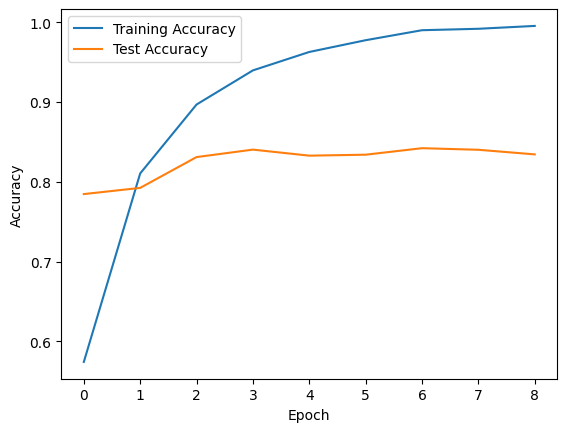

In [15]:
# Train 및 Test Accuracy history 시각화
plt.plot(train_history, label='Training Accuracy')
plt.plot(test_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# 학습
train_history = []
test_history = []
loss_history = []

# EarlyStopping 설정
early_stopping = EarlyStopping(patience=3, verbose=True, mode='max') #mode='min은 손실 기준

# 초기 정확도 설정
best_test_accuracy = 0.0

for e in range(epoch):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("Epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())  # 손실 정보 기록
    print("Epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    test_acc = 0.0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    # 테스트 정확도 평균 계산
    test_acc /= len(test_dataloader)
    print(f'Epoch {e + 1} - Test Accuracy: {test_acc}')

    # 모델 저장 기준 조건
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_epoch = e + 1
        print(f'Validation max increased ({best_test_accuracy:.6f}).  Saving model ...')
        # 모델 저장
        modelsave_location = '/content/drive/MyDrive/Colab Notebooks/modeling_KoBERT_best_test_accuracy.pt'
        torch.save(model.state_dict(), modelsave_location)

    # EarlyStopping 체크
    early_stopping(test_acc, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    test_history.append(test_acc)

# 최종 best test accuracy와 epoch 출력
print(f'Best Test Accuracy: {best_test_accuracy} at Epoch {best_epoch}')

<ipython-input-25-30d9641866a2>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.00016657334344927222 train acc 1.0
epoch 1 train acc 0.9986066878980892


<ipython-input-25-30d9641866a2>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 - Test Accuracy: 0.8385748407643312
Validation max increased (0.838575).  Saving model ...
Validation max increased (-inf --> 0.838575).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.00016363596660085022 train acc 1.0
epoch 2 train acc 0.9976114649681529


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 - Test Accuracy: 0.8272292993630573
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.00026947585865855217 train acc 1.0
epoch 3 train acc 0.9972133757961783


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 - Test Accuracy: 0.8363853503184714
EarlyStopping counter: 2 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0004112892202101648 train acc 1.0
epoch 4 train acc 0.9926353503184714


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 - Test Accuracy: 0.8174761146496815
EarlyStopping counter: 3 out of 3
Early stopping
Best Test Accuracy: 0.8385748407643312 at Epoch 1


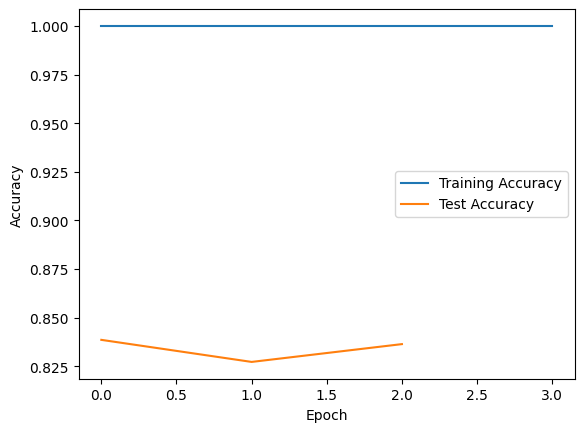

In [26]:
import matplotlib.pyplot as plt

# Train 및 Test Accuracy history 시각화
plt.plot(train_history, label='Training Accuracy')
plt.plot(test_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Test accuracy 기록이 중간에 끊긴다...

In [24]:
# 학습
train_history = []
test_history = []
loss_history = []

# EarlyStopping 설정
early_stopping = EarlyStopping(patience=3, verbose=True, mode='max') #mode='min은 손실 기준

# 초기 정확도 설정
best_test_accuracy = 0.0

for e in range(epoch):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())  # 손실 정보 기록
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # EarlyStopping 적용
    model.eval()
    # test_acc = 0.0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))
    # # 테스트 정확도 평균 계산
    # test_acc /= len(test_dataloader)
    # print(f'Epoch {e + 1} - Test Accuracy: {test_acc}')

    # 모델 저장 기준 조건
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_epoch = e + 1
        print(f'Validation max increased ({best_test_accuracy:.6f}).  Saving model ...')
        # 모델 저장
        modelsave_location = '/content/drive/MyDrive/Colab Notebooks/modeling_KoBERT_best_test_accuracy.pt'
        torch.save(model.state_dict(), modelsave_location)

    # test_history.append(test_acc)

# 최종 best test accuracy와 epoch 출력
print(f'Best Test Accuracy: {best_test_accuracy} at Epoch {best_epoch}')

<ipython-input-24-f012eba517d2>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.002197474939748645 train acc 1.0
epoch 1 train acc 0.9804936305732485


<ipython-input-24-f012eba517d2>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 1 test acc 0.8258359872611465
Validation max increased (129.656250).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.03345388174057007 train acc 0.96875
epoch 2 train acc 0.978702229299363


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 2 test acc 0.8333996815286624
Validation max increased (130.843750).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.06801272928714752 train acc 0.96875
epoch 3 train acc 0.9838773885350318


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 3 test acc 0.8332006369426752


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0018088063225150108 train acc 1.0
epoch 4 train acc 0.9904458598726115


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 4 test acc 0.8409633757961783
Validation max increased (132.031250).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.00048505820450372994 train acc 1.0
epoch 5 train acc 0.9952229299363057


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 5 test acc 0.8385748407643312


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.000428051280323416 train acc 1.0
epoch 6 train acc 0.9970143312101911


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 6 test acc 0.8351910828025477


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.0003818884724751115 train acc 1.0
epoch 7 train acc 0.9990047770700637


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 7 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.0002439725212752819 train acc 1.0
epoch 8 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 8 test acc 0.8365843949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.00021185576042626053 train acc 1.0
epoch 9 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 9 test acc 0.8365843949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.00023045566922519356 train acc 1.0
epoch 10 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.00019598037761170417 train acc 1.0
epoch 11 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.00019361793238203973 train acc 1.0
epoch 12 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.0002094412047881633 train acc 1.0


KeyboardInterrupt: ignored

# **최종**

In [28]:
# 학습
train_history = []
test_history = []
loss_history = []

# EarlyStopping 설정
early_stopping = EarlyStopping(patience=3, verbose=True, mode='max') #mode='min은 손실 기준

# 초기 정확도 설정
best_test_accuracy = 0.0

for e in range(epoch):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("Epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())  # 손실 정보 기록
    print("Epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    test_acc = 0.0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    # 테스트 정확도 평균 계산
    test_acc /= len(test_dataloader)
    print(f'Epoch {e + 1} - Test Accuracy: {test_acc}')

# EarlyStopping 적용
    early_stopping(test_acc, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    test_history.append(test_acc)

    # 모델 저장 기준 조건
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_epoch = e + 1
        print(f'Validation max increased ({best_test_accuracy:.6f}).  Saving model ...')

        # 모델 저장
        modelsave_location = '/content/drive/MyDrive/Colab Notebooks/modeling_KoBERT_best_test_accuracy.pt'
        torch.save(model.state_dict(), modelsave_location)

# 최종 best test accuracy와 epoch 출력
print(f'Best Test Accuracy: {best_test_accuracy} at Epoch {best_epoch}')
#validation max increased 부분이 위와는 다르게 두번씩 출력됨

<ipython-input-28-3bcb73fcc351>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 batch id 1 loss 0.2170526683330536 train acc 0.96875
Epoch 1 train acc 0.9848726114649682


<ipython-input-28-3bcb73fcc351>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 - Test Accuracy: 0.8214570063694268
Validation max increased (-inf --> 0.821457).  Saving model ...
Validation max increased (0.821457).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 batch id 1 loss 0.18221136927604675 train acc 0.96875
Epoch 2 train acc 0.9880573248407644


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 - Test Accuracy: 0.8220541401273885
Validation max increased (0.821457 --> 0.822054).  Saving model ...
Validation max increased (0.822054).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 batch id 1 loss 0.0011592779774218798 train acc 1.0
Epoch 3 train acc 0.9906449044585988


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 - Test Accuracy: 0.8218550955414012
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 batch id 1 loss 0.001893959823064506 train acc 1.0
Epoch 4 train acc 0.9902468152866242


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 - Test Accuracy: 0.8312101910828026
Validation max increased (0.822054 --> 0.831210).  Saving model ...
Validation max increased (0.831210).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 batch id 1 loss 0.00039402430411428213 train acc 1.0
Epoch 5 train acc 0.9928343949044586


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 - Test Accuracy: 0.8322054140127388
Validation max increased (0.831210 --> 0.832205).  Saving model ...
Validation max increased (0.832205).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6 batch id 1 loss 0.0005195265985094011 train acc 1.0
Epoch 6 train acc 0.9924363057324841


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6 - Test Accuracy: 0.8314092356687898
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7 batch id 1 loss 0.0006312821060419083 train acc 1.0
Epoch 7 train acc 0.9952229299363057


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7 - Test Accuracy: 0.8322054140127388
Validation max increased (0.832205 --> 0.832205).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8 batch id 1 loss 0.0001765281194821 train acc 1.0
Epoch 8 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8 - Test Accuracy: 0.8397691082802548
Validation max increased (0.832205 --> 0.839769).  Saving model ...
Validation max increased (0.839769).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9 batch id 1 loss 0.00016227294690907001 train acc 1.0
Epoch 9 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9 - Test Accuracy: 0.8361863057324841
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 batch id 1 loss 0.00014521479897666723 train acc 1.0
Epoch 10 train acc 0.9992038216560509


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 - Test Accuracy: 0.8377786624203821
EarlyStopping counter: 2 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11 batch id 1 loss 0.00011160961730638519 train acc 1.0
Epoch 11 train acc 0.9992038216560509


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11 - Test Accuracy: 0.8383757961783439
EarlyStopping counter: 3 out of 3
Early stopping
Best Test Accuracy: 0.8397691082802548 at Epoch 8


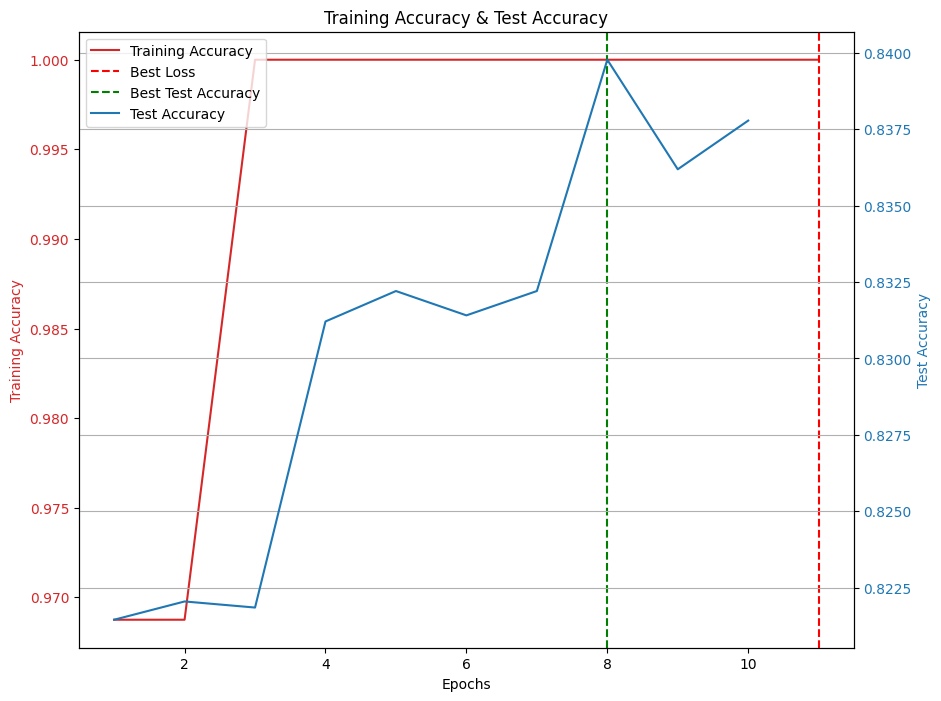

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 8))

# Training Accuracy
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy', color=color)
ax1.plot(range(1, len(train_history) + 1), train_history, color=color, label='Training Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

# Test Accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Test Accuracy', color=color)
ax2.plot(range(1, len(test_history) + 1), test_history, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# validation loss
min_loss_epoch = loss_history.index(min(loss_history)) + 1
ax1.axvline(min_loss_epoch, linestyle='--', color='r', label='Best Loss')

# Best test accuracy
max_test_acc_epoch = test_history.index(max(test_history)) + 1
ax1.axvline(max_test_acc_epoch, linestyle='--', color='g', label='Best Test Accuracy')

# 라벨 표시
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.grid(True)
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Training Accuracy & Test Accuracy')
plt.show()